In [ ]:
!rm -rf /root/.cache/kagglehub/datasets/omkargurav

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Veri kümesini indir
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

# İndirilen dosya yapısını kontrol et
print("Veri kümesinin yolu:", path)

100%|██████████| 163M/163M [00:01<00:00, 154MB/s]

Extracting files...


Veri kümesinin yolu: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# GPU kontrolü
if tf.config.list_physical_devices('GPU'):
    print("GPU kullanılıyor.")
else:
    print("GPU kullanılamıyor. Eğitim CPU üzerinde yapılacak.")

# Veri dizinini belirle
dataset_path = "/root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data"
# Veri yolları
with_mask_path = os.path.join(dataset_path, "with_mask")
without_mask_path = os.path.join(dataset_path, "without_mask")

# Klasördeki dosya sayısını hesapla
with_mask_count = len(os.listdir(with_mask_path))
without_mask_count = len(os.listdir(without_mask_path))

# Sonuçları yazdır
print(f"With Mask Path: {with_mask_path} ({with_mask_count} görüntü)")
print(f"Without Mask Path: {without_mask_path} ({without_mask_count} görüntü)")

# Eğitim ve test klasörlerini oluştur
train_dir = os.path.join(dataset_path, "train")
test_dir = os.path.join(dataset_path, "test")

# Eğitim ve test verilerini ayır
all_with_mask = os.listdir(with_mask_path)
all_without_mask = os.listdir(without_mask_path)

train_with_mask, test_with_mask = train_test_split(all_with_mask, test_size=0.2, random_state=42)
train_without_mask, test_without_mask = train_test_split(all_without_mask, test_size=0.2, random_state=42)

# Eğitim ve test dizinlerine verileri taşıma
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category, data in zip(["with_mask", "without_mask"], [train_with_mask, train_without_mask]):
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(train_dir, category, img))

for category, data in zip(["with_mask", "without_mask"], [test_with_mask, test_without_mask]):
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)
    for img in data:
        os.rename(os.path.join(dataset_path, category, img), os.path.join(test_dir, category, img))

# ImageDataGenerator ile veri artırımı
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Veri yükleyicileri
target_size = (224, 224)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# DenseNet121 Modeli
base_model_dense = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_dense.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_dense = Model(inputs=base_model_dense.input, outputs=predictions)
model_dense.summary()

# MobileNetV1 Modeli
base_model_mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model_mobilenet.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # İki sınıf: Maskeli ve Masksiz

model_mobilenet = Model(inputs=base_model_mobilenet.input, outputs=predictions)
model_mobilenet.summary()

# Eğitim Parametreleri
early_stopping = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)



GPU kullanılıyor.
With Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/with_mask (3725 görüntü)
Without Mask Path: /root/.cache/kagglehub/datasets/omkargurav/face-mask-dataset/versions/1/data/without_mask (3828 görüntü)
Found 6042 images belonging to 2 classes.
Found 1511 images belonging to 2 classes.


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 7,323,330 (27.94 MB)

 Non-trainable params: 83,648 (326.75 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,598,338 (13.73 MB)

 Trainable params: 3,576,450 (13.64 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
# DenseNet121 Modeli için optimizer
optimizer_dense = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer_dense, loss='categorical_crossentropy', metrics=['accuracy'])

history_dense = model_dense.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 265s 764ms/step - accuracy: 0.9188 - loss: 0.1959 - val_accuracy: 0.7988 - val_loss: 0.9633 - learning_rate: 0.0010
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 353ms/step - accuracy: 0.9783 - loss: 0.0720 - val_accuracy: 0.9749 - val_loss: 0.1017 - learning_rate: 0.0010
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 351ms/step - accuracy: 0.9808 - loss: 0.0509 - val_accuracy: 0.9735 - val_loss: 0.1239 - learning_rate: 0.0010
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 355ms/step - accuracy: 0.9743 - loss: 0.0683 - val_accuracy: 0.9815 - val_loss: 0.0770 - learning_rate: 0.0010
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 356ms/step - accuracy: 0.9864 - loss: 0.0392 - val_accuracy: 0.8127 - val_loss: 0.3684 - learning_rate: 0.0010
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 352ms/step - accuracy: 0.9793 - loss: 0.0571 - val_accuracy: 0.9914 - val_loss: 0.0297 - learning_rate: 0.0010
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 355ms/step - accur

In [ ]:
# MobileNet Modeli için optimizer
optimizer_mobilenet = Adam(learning_rate=0.001)
model_mobilenet.compile(optimizer=optimizer_mobilenet, loss='categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_test_generator,
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 116s 454ms/step - accuracy: 0.9176 - loss: 0.1812 - val_accuracy: 0.9762 - val_loss: 0.1122 - learning_rate: 0.0010
Epoch 2/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 355ms/step - accuracy: 0.9917 - loss: 0.0265 - val_accuracy: 0.9921 - val_loss: 0.0303 - learning_rate: 0.0010
Epoch 3/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.9926 - loss: 0.0252 - val_accuracy: 0.9940 - val_loss: 0.0210 - learning_rate: 0.0010
Epoch 4/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 353ms/step - accuracy: 0.9938 - loss: 0.0183 - val_accuracy: 0.9623 - val_loss: 0.1442 - learning_rate: 0.0010
Epoch 5/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 69s 354ms/step - accuracy: 0.9927 - loss: 0.0219 - val_accuracy: 0.9755 - val_loss: 0.0760 - learning_rate: 0.0010
Epoch 6/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 356ms/step - accuracy: 0.9953 - loss: 0.0194 - val_accuracy: 0.9927 - val_loss: 0.0270 - learning_rate: 0.0010
Epoch 7/100
189/189 ━━━━━━━━━━━━━━━━━━━━ 70s 356ms/step - accur

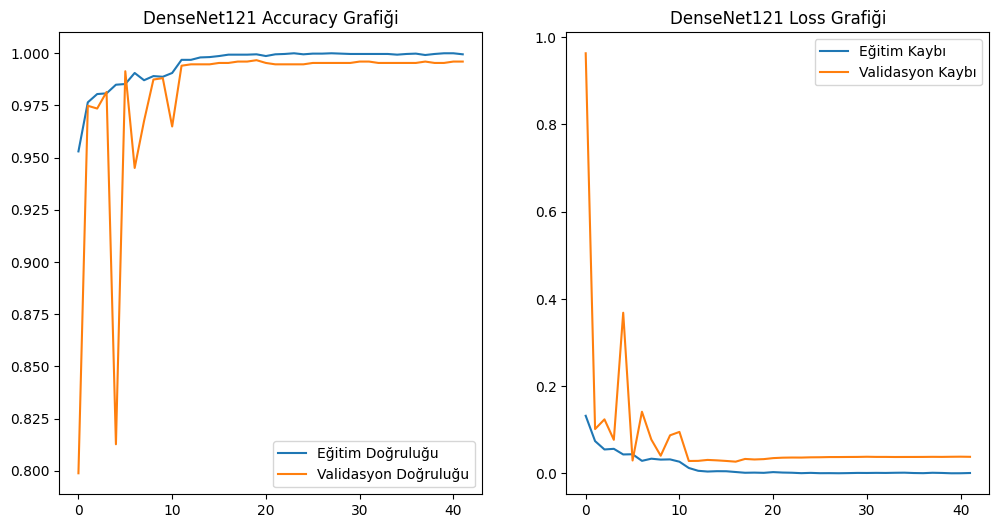

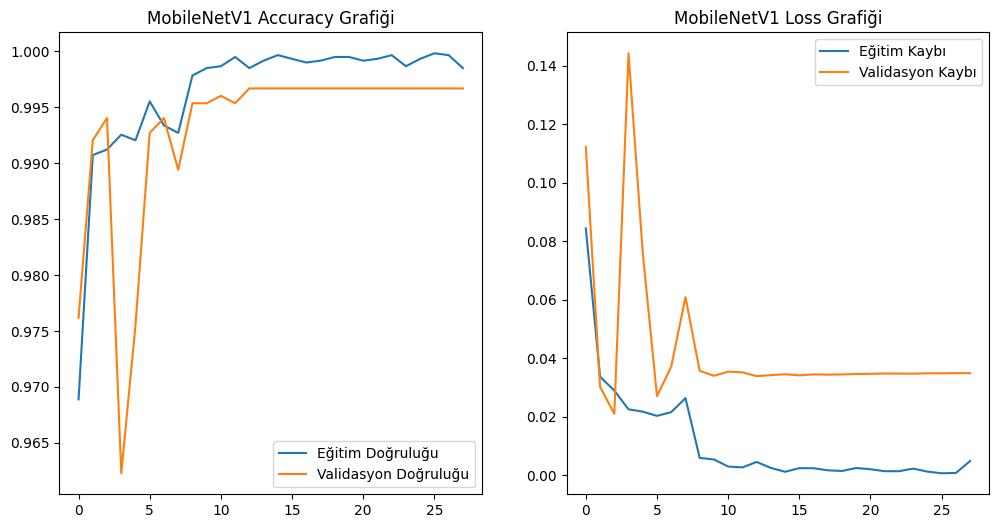

In [ ]:
# Eğitim Sonuçlarının Görselleştirilmesi

def plot_training(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Eğitim Doğruluğu')
    plt.plot(val_acc, label='Validasyon Doğruluğu')
    plt.title(f'{title} Accuracy Grafiği')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Eğitim Kaybı')
    plt.plot(val_loss, label='Validasyon Kaybı')
    plt.title(f'{title} Loss Grafiği')
    plt.legend()
    plt.show()

plot_training(history_dense, "DenseNet121")
plot_training(history_mobilenet, "MobileNetV1")

# **Model Yorumları**
# **DenseNet121 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu hızla yükselerek 1.0 değerine yaklaşıyor.
Validasyon doğruluğu da benzer bir şekilde artış gösteriyor ancak bazı dalgalanmalar var.
İlk birkaç epoch boyunca validasyon doğruluğunda ani düşüşler mevcut. Ancak ilerleyen epoch’larda stabil hale geliyor ve eğitim doğruluğuna yakın bir değerde seyrediyor.
Sonuç olarak model oldukça yüksek doğruluk elde etmiş.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı oldukça düşük seviyelere iniyor ve stabil hale geliyor.
Validasyon kaybı ise başlarda büyük dalgalanmalar gösteriyor ancak sonrasında azalarak belirli bir seviyede kalıyor.
Eğitimin başında validasyon kaybında büyük sıçramalar var, ancak model eğitildikçe daha kararlı hale geliyor.
* DenseNet121 modeli genel olarak başarılı görünüyor. Başlangıçtaki validasyon
doğruluğundaki ve kayıptaki dalgalanmalar, eğitim sürecinde modelin veriyle uyum sağlamaya çalıştığını gösteriyor. Ancak, doğruluk değerleri neredeyse 1.0 seviyesinde olduğu için modelin overfitting (aşırı öğrenme) riski olabilir. Daha fazla genel performans değerlendirmesi için test verisi üzerinde denemeler yapılmalı.

# **MobileNetV1 Modeli**
* **Accuracy (Doğruluk) Grafiği:**
Eğitim doğruluğu 1.0 seviyesine çok yaklaşıyor.
Validasyon doğruluğu ise hızlı bir şekilde yükseliyor ve erken bir aşamada (yaklaşık 10. epoch civarında) sabitleniyor.
Validasyon doğruluğu eğitim doğruluğundan biraz daha düşük kalıyor, ancak aralarındaki fark çok büyük değil.
* **Loss (Kayıp) Grafiği:**
Eğitim kaybı hızla düşüyor ve çok düşük seviyelere ulaşıyor.
Validasyon kaybı başlarda dalgalanmalar gösteriyor ancak sonrasında sabit bir değere yerleşiyor.
MobileNetV1 modeli de belirli bir seviyede stabil hale geliyor ve kayıp oranı düşük seyrediyor.
*MobileNetV1 modeli de iyi bir performans gösteriyor. DenseNet121 ile karşılaştırıldığında, daha az dalgalanma ve daha erken stabilizasyon göze çarpıyor. Bu durum MobileNetV1’in daha hızlı ve stabil bir öğrenme süreci gösterdiğini düşündürebilir. Ancak yine de modelin genel performansı test verileri ile doğrulanmalı.


---


* DenseNet121’de validasyon doğruluğunda ve kaybında biraz daha fazla dalgalanma var. Bu, modelin eğitimin başında daha hassas olduğunu ve veri dağılımına adapte olmaya çalıştığını gösteriyor.
* MobileNetV1 daha stabil bir performans gösteriyor gibi görünüyor. Validasyon doğruluğu belirli bir seviyeye erken ulaşıyor ve daha az dalgalanma var.

Found 1511 images belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


48/48 ━━━━━━━━━━━━━━━━━━━━ 21s 245ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 111ms/step


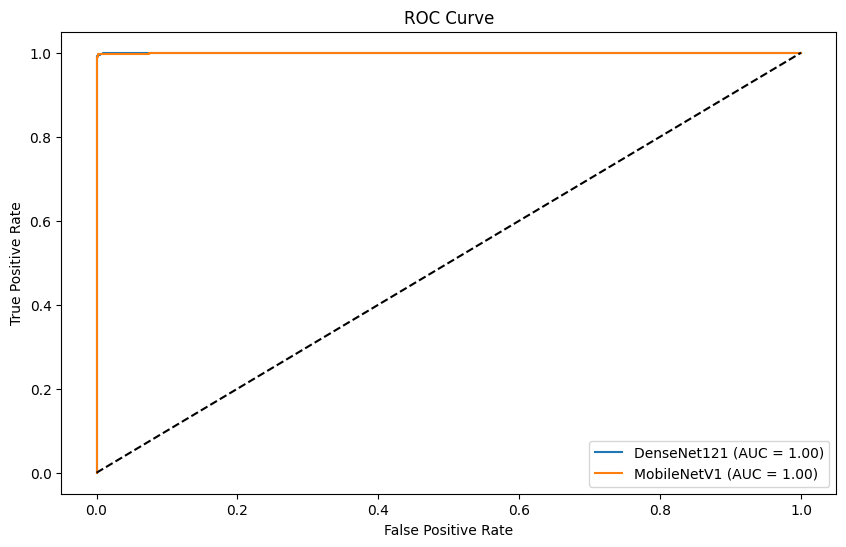

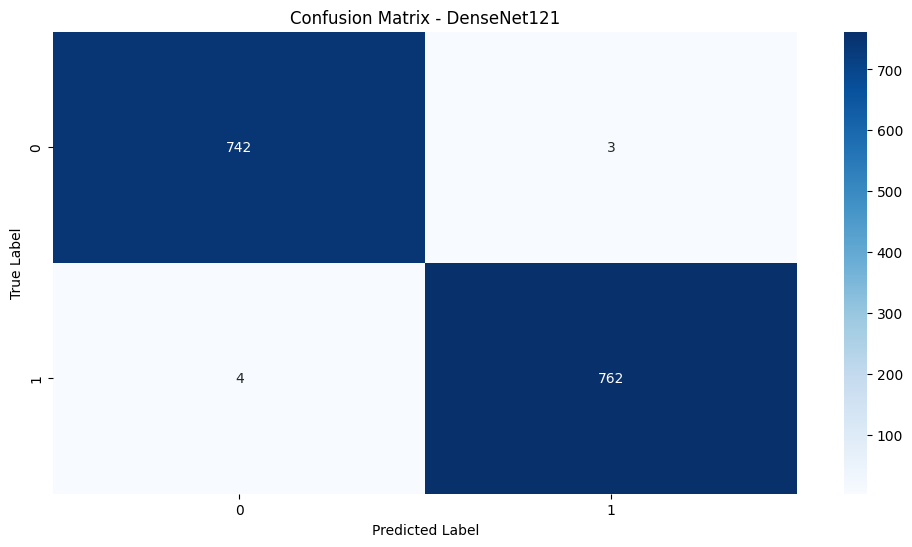

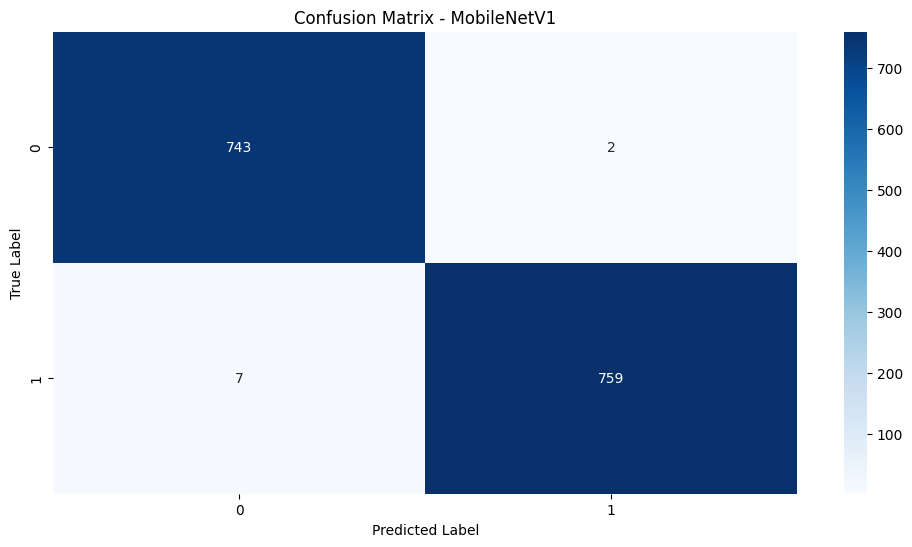


DenseNet121 Model Metrics:
Accuracy: 0.9954
Precision: 0.9961
Recall: 0.9948
Specificity: 0.9960
F1-Score: 0.9954

MobileNetV1 Model Metrics:
Accuracy: 0.9940
Precision: 0.9974
Recall: 0.9909
Specificity: 0.9973
F1-Score: 0.9941

Classification Report - DenseNet121
              precision    recall  f1-score   support

   with_mask       0.99      1.00      1.00       745
without_mask       1.00      0.99      1.00       766

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511


Classification Report - MobileNetV1
              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       745
without_mask       1.00      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import tensorflow as tf

# Test set üzerinde tahmin
best_model_dense = model_dense
best_model_mobilenet = model_mobilenet

# Tahminler (inference) için test verisini yükleyin
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# DenseNet Modeli ile Tahmin
pred_dense = best_model_dense.predict(test_generator)
y_pred_dense = np.argmax(pred_dense, axis=1)
y_true = test_generator.classes

# MobileNet Modeli ile Tahmin
pred_mobilenet = best_model_mobilenet.predict(test_generator)
y_pred_mobilenet = np.argmax(pred_mobilenet, axis=1)

# ROC ve AUC Hesaplama
fpr_dense, tpr_dense, _ = roc_curve(y_true, pred_dense[:, 1])
roc_auc_dense = auc(fpr_dense, tpr_dense)

fpr_mobilenet, tpr_mobilenet, _ = roc_curve(y_true, pred_mobilenet[:, 1])
roc_auc_mobilenet = auc(fpr_mobilenet, tpr_mobilenet)

# ROC Eğrisi Çizimi
plt.figure(figsize=(10, 6))
plt.plot(fpr_dense, tpr_dense, label=f'DenseNet121 (AUC = {roc_auc_dense:.2f})')
plt.plot(fpr_mobilenet, tpr_mobilenet, label=f'MobileNetV1 (AUC = {roc_auc_mobilenet:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix Hesaplama ve Çizim
conf_matrix_dense = confusion_matrix(y_true, y_pred_dense)
conf_matrix_mobilenet = confusion_matrix(y_true, y_pred_mobilenet)

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_dense, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - DenseNet121')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(conf_matrix_mobilenet, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - MobileNetV1')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Metriklerin Hesaplanması
for model_name, y_pred in zip(['DenseNet121', 'MobileNetV1'], [y_pred_dense, y_pred_mobilenet]):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)

    print(f"\n{model_name} Model Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Specificity: {specificity:.4f}")
    print(f"F1-Score: {f1:.4f}")

# Classification Report (isteğe bağlı detaylı rapor)
print("\nClassification Report - DenseNet121")
print(classification_report(y_true, y_pred_dense, target_names=test_generator.class_indices.keys()))

print("\nClassification Report - MobileNetV1")
print(classification_report(y_true, y_pred_mobilenet, target_names=test_generator.class_indices.keys()))

# **Test Yorumları**
# **Confusion Matrix**

* DenseNet121, MobileNetV1'e kıyasla biraz daha iyi görünüyor çünkü yanlış tahmin oranı daha düşük.
* MobileNetV1 modelinde false negative sayısı daha fazla (7 vs. 4), yani maskesiz olanları maskeli olarak tahmin etme hatası biraz daha yüksek.
* False positive ve false negative sayıları oldukça düşük, bu da modellerin iyi genelleştirme yaptığını gösteriyor.
* Genel doğruluk çok yüksek olduğu için her iki model de başarılı sayılır.

# **ROC Curve (AUC Skoru)**
* Hem DenseNet121 hem de MobileNetV1 modellerinin AUC skoru 1.00 olarak görünüyor. Bu, modelin mükemmel ayırma yeteneğine sahip olduğunu gösteriyor.
ROC eğrisine bakıldığında, neredeyse mükemmel bir sınıflandırma performansı var.
* AUC değerinin 1.00 olması çok ideal bir sonuç. Ancak bu durum, modelin overfitting yapmış olabileceğini gösteriyor olabilir. Test setinde de aynı performansı koruyup korumadığını görmek önemli.

# **Model Metriği Karşılaştırması**
* Model ------------ Accuracy -- Precision -- Recall -- Specificity -- F1-Score
* DenseNet121 -- 0.9954 ---- 0.9961 ---- 	0.9948 ---- 	0.9960 ---- 	0.9954
* MobileNetV1 -- 0.9940 ---- 	0.9974 ---- 0.9909 ---- 0.9973 ---- 0.9941
* Metriğin Anlamı:
* Accuracy (Doğruluk): Genel olarak test verisinde modelin ne kadar doğru tahmin yaptığı. DenseNet121 daha yüksek.
* Precision (Kesinlik): Modelin tahmin ettiği maskesiz vakalarının ne kadarının gerçekten maskesiz olduğu. MobileNetV1 burada biraz daha iyi.
* Recall (Duyarlılık): Gerçekten maskesiz olan vakaların ne kadarını doğru tahmin edebildiği. DenseNet121 burada daha iyi.
* Specificity (Özgüllük): Maskeli vakaların ne kadarının doğru tahmin edildiği. MobileNetV1 burada bir tık daha iyi.
* F1-Score: Precision ve Recall’un dengeli bir ölçümü. DenseNet121 biraz daha yüksek.
---
DenseNet121 genel olarak daha iyi recall ve accuracy sunuyor, bu da modelin daha sağlam tahmin yaptığını gösteriyor.
MobileNetV1 precision açısından biraz daha iyi, yani maskesiz tahminlerinin yanlış olma oranı daha düşük.
Ancak farklar çok küçük, dolayısıyla daha hızlı çalışan bir model gerekiyorsa MobileNetV1 de tercih edilebilir.
